In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Causality-Experiments/Paper1/notebooks/multivariate"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1i7sSt69-Q0ifBm21oC5B4EqD8-3EkGV8/Causality-Experiments/Paper1/notebooks/multivariate


In [2]:
!python -m pip install -r "../../requirements.txt"

     |███                             | 54.2MB 2.4MB/s eta 0:03:43ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 425, in _error_catcher
    yield
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 507, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.6/http/client.py", line 463, in read
    n = self.readinto(b)
  File "/usr/lib/python3.6/http/client.py", line 507, in readinto
    n = self.fp.readinto(b)
  File "/usr/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.6/ssl.py", line 1012, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.6/ssl.py", line 874, in read
    return self._sslobj.read(len, buffer)


In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../causal_meta/models')
sys.path.insert(0, '../../causal_meta/modules')
sys.path.insert(0, '../../causal_meta/utils')

In [3]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook

import torch.nn.functional as F
from categorical import Marginal, Conditional, BiConditional
from data_utils_Ext import generate_data_categorical_extended
from models3 import *
from binary_ext import BinaryStructuralModel_extended

# Adaptation to transfer distribution

In [20]:
N = 10
model_1 = ModelA2BC(Marginal(N), Conditional(N), Conditional(N))
model_2 = ModelB2AC(Marginal(N), Conditional(N), Conditional(N))
model_3 = ModelC2AB(Marginal(N), Conditional(N), Conditional(N))
model_4 = ModelA2BC_B2C(Marginal(N), BiConditional(N), Conditional(N))
model_5 = ModelA2BC_C2B(Marginal(N), BiConditional(N), Conditional(N))
model_6 = ModelB2AC_A2C(Marginal(N), BiConditional(N), Conditional(N))
model_7 = ModelB2AC_C2A(Marginal(N), BiConditional(N), Conditional(N))
model_8 = ModelC2AB_A2B(Marginal(N), BiConditional(N), Conditional(N))
model_9 = ModelC2AB_B2A(Marginal(N), BiConditional(N), Conditional(N))

model = BinaryStructuralModel_extended(model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9)
real_model = ModelA2BC_B2C

In [21]:
num_episodes = 500
batch_size = 100 # 1
num_test = 10000
num_training = 10 # 100
num_transfers = 10 # 100

In [22]:
optimizer = torch.optim.SGD(model.modules_parameters(), lr=1.)

In [23]:
losses = np.zeros((9, num_training, num_transfers, num_episodes))

for k in tnrange(num_training):
    pi_A_1 = np.random.dirichlet(np.ones(N))
    pi_B_A = np.transpose(np.random.dirichlet(np.ones(N), size=N), (1, 0))
    pi_C_AB = np.transpose(np.random.dirichlet(np.ones(N), size=(N, N)), (2, 0, 1))
    for j in tnrange(num_transfers, leave=False):
        model.set_ground_truth(real_model, pi_A_1, pi_C_AB, pi_B_A)
        pi_A_2 = np.random.dirichlet(np.ones(N))
        x_val = torch.from_numpy(generate_data_categorical_extended(num_test, pi_A_2, pi_B_A, pi_C_AB))
        for i in range(num_episodes):
            x_transfer = torch.from_numpy(generate_data_categorical_extended(batch_size, pi_A_2, pi_B_A, pi_C_AB))
            model.zero_grad()
            loss_1 = -torch.mean(model.model_1(x_transfer))
            loss_2 = -torch.mean(model.model_2(x_transfer))
            loss_3 = -torch.mean(model.model_3(x_transfer))
            loss_4 = -torch.mean(model.model_4(x_transfer))
            loss_5 = -torch.mean(model.model_5(x_transfer))
            loss_6 = -torch.mean(model.model_6(x_transfer))
            loss_7 = -torch.mean(model.model_7(x_transfer))
            loss_8 = -torch.mean(model.model_8(x_transfer))
            loss_9 = -torch.mean(model.model_9(x_transfer))
            loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9
            
            with torch.no_grad():
                val_loss_1 = -torch.mean(model.model_1(x_val))
                val_loss_2 = -torch.mean(model.model_2(x_val))
                val_loss_3 = -torch.mean(model.model_3(x_val))
                val_loss_4 = -torch.mean(model.model_4(x_val))
                val_loss_5 = -torch.mean(model.model_5(x_val))
                val_loss_6 = -torch.mean(model.model_6(x_val))
                val_loss_7 = -torch.mean(model.model_7(x_val))
                val_loss_8 = -torch.mean(model.model_8(x_val))
                val_loss_9 = -torch.mean(model.model_9(x_val))

            losses[:, k, j, i] = [val_loss_1.item(), val_loss_2.item(), val_loss_3.item(), val_loss_4.item(), val_loss_5.item(), val_loss_6.item(), val_loss_7.item(), val_loss_8.item(), val_loss_9.item()]

            loss.backward()
            optimizer.step()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


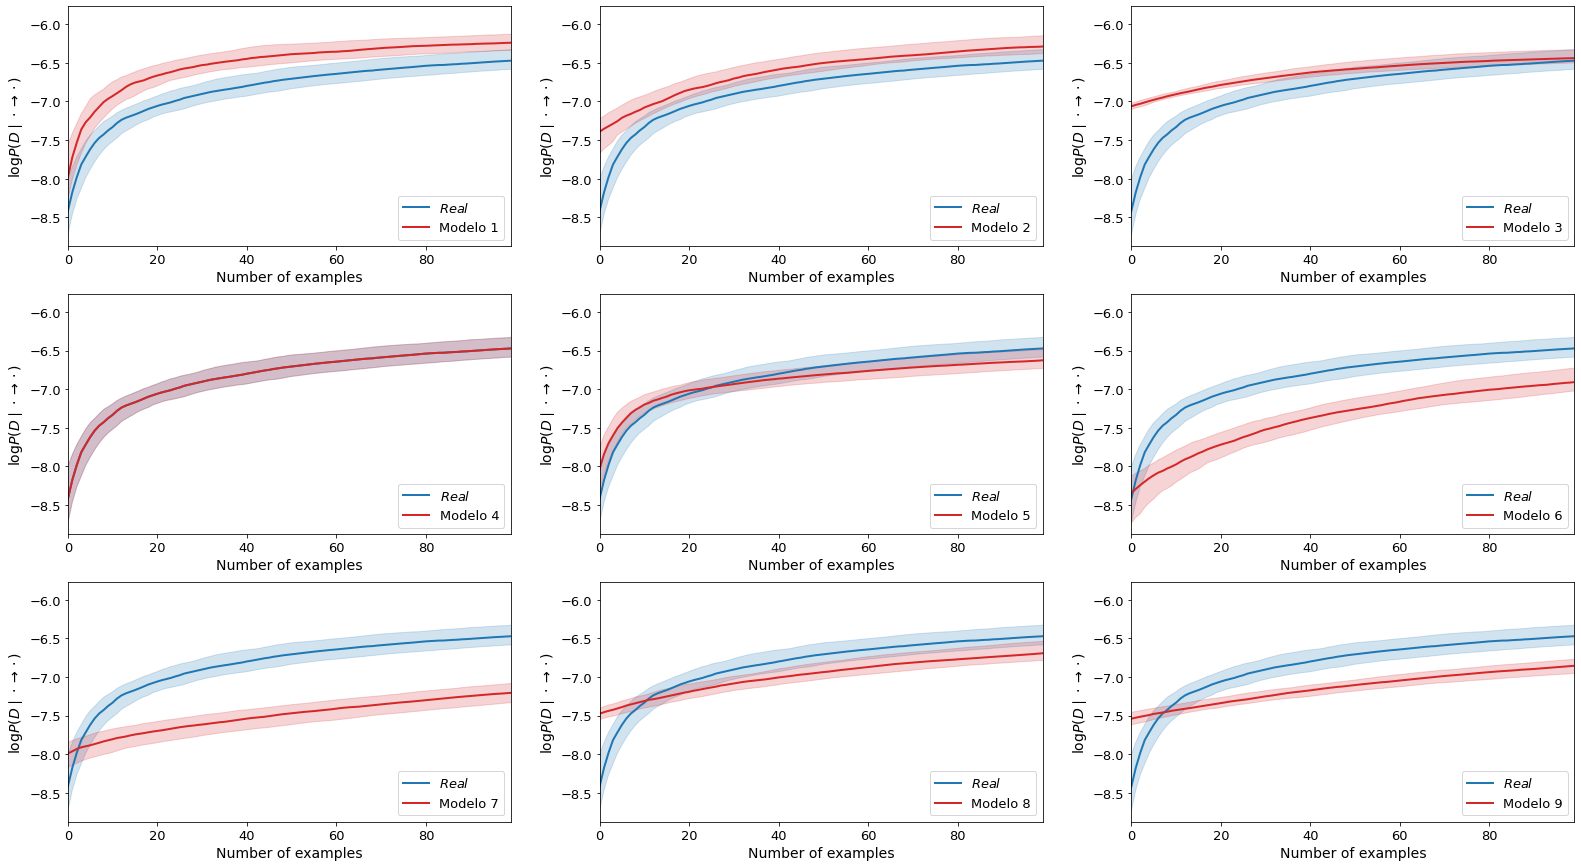

In [25]:
flat_losses = -losses.reshape((9, -1, num_episodes))
losses_25, losses_50, losses_75 = np.percentile(flat_losses, (25, 50, 75), axis=1)

fig, ax = plt.subplots(3, 3, figsize=(27, 15))

ind1 = 3
ind2 = 0

for ind2 in range(9):
    i_x = ind2 // 3
    i_y = ind2 % 3
    ax[i_x, i_y].plot(losses_50[ind1], color='C0', label=r'$Real$', lw=2)
    ax[i_x, i_y].fill_between(np.arange(num_episodes), losses_25[ind1], losses_75[ind1], color='C0', alpha=0.2)
    ax[i_x, i_y].plot(losses_50[ind2], color='C3', label=f'Modelo {ind2 + 1}', lw=2)
    ax[i_x, i_y].fill_between(np.arange(num_episodes), losses_25[ind2], losses_75[ind2], color='C3', alpha=0.2)
    ax[i_x, i_y].set_xlim([0, flat_losses.shape[1] - 1])
    ax[i_x, i_y].tick_params(axis='both', which='major', labelsize=13)
    ax[i_x, i_y].legend(loc=4, prop={'size': 13})
    ax[i_x, i_y].set_xlabel('Number of examples', fontsize=14)
    ax[i_x, i_y].set_ylabel(r'$\log P(D\mid \cdot \rightarrow \cdot)$', fontsize=14)

plt.show()

# Meta Learning

In [9]:
N = 10
model_1 = ModelA2BC(Marginal(N), Conditional(N), Conditional(N))
model_2 = ModelB2AC(Marginal(N), Conditional(N), Conditional(N))
model_3 = ModelC2AB(Marginal(N), Conditional(N), Conditional(N))
model_4 = ModelA2BC_B2C(Marginal(N), BiConditional(N), Conditional(N))
model_5 = ModelA2BC_C2B(Marginal(N), BiConditional(N), Conditional(N))
model_6 = ModelB2AC_A2C(Marginal(N), BiConditional(N), Conditional(N))
model_7 = ModelB2AC_C2A(Marginal(N), BiConditional(N), Conditional(N))
model_8 = ModelC2AB_A2B(Marginal(N), BiConditional(N), Conditional(N))
model_9 = ModelC2AB_B2A(Marginal(N), BiConditional(N), Conditional(N))

model = BinaryStructuralModel_extended(model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9)
real_model = ModelA2BC_B2C

In [10]:
optimizer = torch.optim.SGD(model.modules_parameters(), lr=1e-1)
meta_optimizer = torch.optim.RMSprop([model.w1, model.w2, model.w3, model.w4, model.w5, model.w6, model.w7, model.w8, model.w9], lr=1e-2)

In [11]:
num_runs = 1 # 10
num_training = 1 # 100
num_transfer = 1000
num_gradient_steps = 2

train_batch_size = 1000
transfer_batch_size = 10

In [12]:
torch.autograd.set_detect_anomaly(True)
alphas = np.zeros((9, num_runs, num_training, num_transfer))

for j in tnrange(num_runs):
    #model.w.data.zero_()
    for i in range(9):
        getattr(model, f'w{i + 1}').data.zero_()

    for i in tnrange(num_training, leave=False):
        # Step 1: Sample a joint distribution before intervention
        pi_A_1 = np.random.dirichlet(np.ones(N))
        pi_B_A = np.transpose(np.random.dirichlet(np.ones(N), size=N), (1, 0))
        pi_C_AB = np.transpose(np.random.dirichlet(np.ones(N), size=(N, N)), (2, 0, 1))
        
        transfers = tnrange(num_transfer, leave=False)
        for k in transfers:
            # Step 2: Train the modules on the training distribution
            model.set_ground_truth(real_model, pi_A_1, pi_C_AB, pi_B_A)
            # Step 3: Sample a joint distribution after intervention
            pi_A_2 = np.random.dirichlet(np.ones(N))

            # Step 4: Do k steps of gradient descent for adaptation on the
            # distribution after intervention
            model.zero_grad()
            loss = torch.tensor(0., dtype=torch.float64)
            for _ in range(num_gradient_steps):
                x_train = torch.from_numpy(generate_data_categorical_extended(transfer_batch_size, pi_A_2, pi_B_A, pi_C_AB))
                loss = loss - torch.mean(model(x_train))
                optimizer.zero_grad()
                loss_1 = -torch.mean(model.model_1(x_train))
                loss_2 = -torch.mean(model.model_2(x_train))
                loss_3 = -torch.mean(model.model_3(x_train))
                loss_4 = -torch.mean(model.model_4(x_train))
                loss_5 = -torch.mean(model.model_5(x_train))
                loss_6 = -torch.mean(model.model_6(x_train))
                loss_7 = -torch.mean(model.model_7(x_train))
                loss_8 = -torch.mean(model.model_8(x_train))
                loss_9 = -torch.mean(model.model_9(x_train))
                inner_loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9
                inner_loss.backward()
                optimizer.step()

            # Step 5: Update the structural parameter alpha
            meta_optimizer.zero_grad()
            loss.backward()
            meta_optimizer.step()

            # Log the values of alpha
            with torch.no_grad():
                ws = torch.cat([model.w1.reshape(1, -1), model.w2.reshape(1, -1), model.w3.reshape(1, -1), model.w4.reshape(1, -1), model.w5.reshape(1, -1), model.w6.reshape(1, -1), model.w7.reshape(1, -1), model.w8.reshape(1, -1), model.w9.reshape(1, -1)], dim=0)
                smax = F.softmax(ws, dim=0)
                alphas[0, j, i, k] = smax[0, 0].item()
                alphas[1, j, i, k] = smax[1, 0].item()
                alphas[2, j, i, k] = smax[2, 0].item()
                alphas[3, j, i, k] = smax[3, 0].item()
                alphas[4, j, i, k] = smax[4, 0].item()
                alphas[5, j, i, k] = smax[5, 0].item()
                alphas[6, j, i, k] = smax[6, 0].item()
                alphas[7, j, i, k] = smax[7, 0].item()
                alphas[8, j, i, k] = smax[8, 0].item()
            #transfers.set_postfix(alpha='{0:.4f}'.format(alpha), grad='{0:.4f}'.format(model.w.grad.item()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  from ipykernel import kernelapp as app


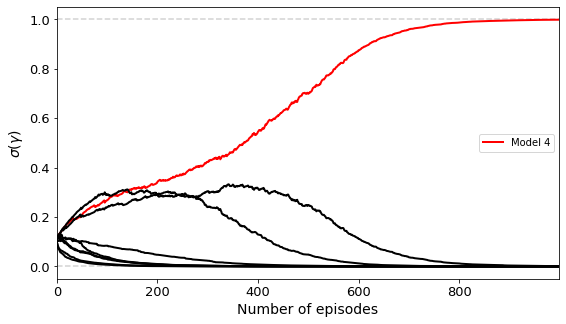

In [14]:
alphas_50 = np.percentile(alphas.reshape((9, -1, num_transfer)), 50, axis=1)

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
for i in range(9):
    if i == 3:
        ax.plot(alphas_50[i], lw=2, color='r', label=f'Model {i + 1}')

    else:
        ax.plot(alphas_50[i], lw=2, color='k')

ax.set_xlim([0, num_transfer - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\gamma)$', fontsize=14)
ax.legend()
plt.show()